In [75]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
'''
 Rehder, Bob, and Aaron B. Hoffman. (2005). Thirty-Something Categorization
 Results Explained: Selective Attention, Eyetracking, and Models of Category
 Learning. Journal of Experimental Psychology: Learning, Memory, and Cognition
 31(5). 811–29. https://doi.org/10.1037/0278-7393.31.5.811.
'''

%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import sys
sys.path.append('..')
import sea


In [2]:
# %% simulation parameters
param = {
    # how many steps one looksahead? 0 is myopic (1 step ahead) and so on..
    'MAX_RECURSION_LEVEL':  5,
    'EXPLORATION_PARAM':    0.0,
    'DECISION_PARAMETER':   1.0,
    'TOTAL_BLOCKS':         21,
    'CONSEC_BLOCKS':        2,
    'prior_matrix':         np.array([[.01, .01],
                              [1.0, 1.0],
                              [1.0, 1.0, ],
                              [1.0, 1.0],
                              [1.0, 1.0]]),
    'num_dims':             5,
    'num_values':           2,
    'coupling':             .3,
    'd':                    1.0,
    'report':               False,
    'NUM_TIMES':            1000,
}


# uses a binary feature (one unit) for the first three dims and two
# features for the output to facillitate choice.
MS_STIM = np.array([[0, 1, 1, 1, 0],
                    [0, 1, 0, 1, 0],
                    [0, 1, 0, 1, 1],
                    [0, 1, 1, 0, 1],
                    [0, 0, 1, 1, 1],
                    [1, 1, 1, 0, 0],
                    [1, 0, 1, 1, 0],
                    [1, 0, 0, 0, 1],
                    [1, 0, 0, 0, 0]])

MS_TRANS_STIM = np.array([[0, 1, 0, 0, 1],
                          [0, 1, 0, 0, 0],
                          [0, 1, 1, 1, 1],
                          [0, 0, 0, 1, 0],
                          [0, 0, 1, 0, 1],
                          [0, 0, 0, 1, 1],
                          [0, 0, 1, 0, 0]])


# features known during stimulus presentation
MS_KNOWN = np.array([0, 1, 1, 1, 1])

MS_QUERY = np.array([1, 0, 0, 0, 0])


In [3]:
# functions for computing utility:


def getSituationCost(KNOWN_VEC, param):
    '''function to calculate costs for a given KNOWN_VEC (see RMC.SituationValue)

    This function assumes equal costs for each query. Can be modified for
    tasks in which some tests are more costly than others, or when sampling costs
    are not independent.'''
    return np.sum(KNOWN_VEC) * 10


def dfActionVals(param):
    '''function to define utility table (e.g., table 1)
    returns dataframe
    '''
    m = np.diag([100] * param['num_values'])
    df = pd.DataFrame(index=['s%d' % a for a in range(param['num_values'])],
                      columns=['a%d' % a for a in range(param['num_values'])],
                      data=m)
    return df


param['getSituationCost'] = getSituationCost
param['dfActionVals'] = dfActionVals(param)


In [4]:
# %% Simulation

model = sea.RMC(param)

blocks_correct_consec   = 0
overall_correct         = np.zeros([param['TOTAL_BLOCKS']])
overall_sampled         = np.zeros([param['TOTAL_BLOCKS']])
item_order              = np.arange(9)
totalTransDimSampled    = 0
dimSampledFirst         = np.array([0, 0, 0, 0])
transAccuracy           = 0
proportionTrialsSampled = np.array([0, 0, 0, 0, 0])
transferProbA           = np.zeros(16)
transSamplesAll         = np.array([0, 0, 0, 0])
transSampleFirst        = np.array([0, 0, 0, 0])
transItemSamples        = np.reshape(np.array(np.zeros(16 * 4)), (16, 4))
samplesByBlock          = np.zeros((param['TOTAL_BLOCKS'], 5))

allSamples = []


dfTransDimSampled = pd.DataFrame(
    index=range(param['NUM_TIMES'] *16),
    columns=['run', 'item', 'D1', 'D2',  'D3', 'D4'])

itrDimSamp = -1
for run_num in tqdm(range(param['NUM_TIMES']),desc='run'):

    model.Reset()
    sim_correct = np.zeros(param['TOTAL_BLOCKS'])
    numberDimSampled = np.zeros(param['TOTAL_BLOCKS'])
    allSamples.append([])

    for num_block in range(param['TOTAL_BLOCKS']):
        np.random.shuffle(item_order)
        blockCorrectProb = 1.0

        for wbi, item_num in enumerate(item_order):
            tempN = model.PresentStimulus(MS_STIM[item_num], MS_KNOWN)
            allSamples[run_num].append([item_num, tempN])
            dimSampledFirst[tempN[0] - 1] += 1

            SAMPLED_KNOWN = np.zeros(model.NUM_DIMS, dtype=int)
            SAMPLED_KNOWN[tempN] = 1

            proportionTrialsSampled += SAMPLED_KNOWN
            samplesByBlock[num_block] += SAMPLED_KNOWN

            numberDimSampled[num_block] += len(tempN)
            correctProb = model.ResponseCorrectProb(
                MS_STIM[item_num], SAMPLED_KNOWN)
            blockCorrectProb *= correctProb
            sim_correct[num_block] += correctProb
            model.Learn(MS_STIM[item_num], SAMPLED_KNOWN, MS_QUERY)

        if np.random.uniform(0, 1) < blockCorrectProb:
            blocks_correct_consec += 1
        else:
            blocks_correct_consec = 0

        if blocks_correct_consec == param['CONSEC_BLOCKS']:
            sim_correct[(num_block + 1):] = 9.
            numberDimSampled[(num_block +
                              1):] += float(numberDimSampled[num_block])

            # repeat eye fixation pattern from last block
            last9 = allSamples[run_num][-9:]
            last9 = last9 * (param['TOTAL_BLOCKS'] - (num_block + 1))
            allSamples[run_num] = allSamples[run_num] + last9
            break

    # TRANSFER ------------------------------------------------------------
    for item in range(16):
        if item < 9:
            tempN = model.PresentStimulus(MS_STIM[item], MS_KNOWN)
        else:
            tempN = model.PresentStimulus(MS_TRANS_STIM[item - 9], MS_KNOWN)

        for z in tempN:
            transItemSamples[item][z - 1] += 1

        transferProbA[item] += model.Fpredictions[0, 0]

        itrDimSamp += 1
        dfTransDimSampled.loc[itrDimSamp, :] = np.zeros(
            dfTransDimSampled.shape[1])
        dfTransDimSampled.loc[itrDimSamp, ['run', 'item']] = run_num, item

        SAMPLED_KNOWN = np.zeros(model.NUM_DIMS, dtype=int)
        SAMPLED_KNOWN[tempN] = 1
        transSamplesAll += SAMPLED_KNOWN[1:]
        dfTransDimSampled.loc[itrDimSamp, [
            'D1', 'D2', 'D3', 'D4']] += SAMPLED_KNOWN[1:]
        transSampleFirst[tempN[0] - 1] += 1

    overall_correct += sim_correct
    overall_sampled += numberDimSampled

# print('overall_sampled', overall_sampled / (param['NUM_TIMES'] * 9))
# print('pc correct by block:', overall_correct / (param['NUM_TIMES'] * 9))


run: 100%|██████████| 1000/1000 [10:38:05<00:00, 29.62s/it] 



dims sampled at transfer by item: 
[[0.963 0.105 0.946 0.322]
 [0.935 0.106 0.937 0.257]
 [0.817 0.087 0.828 0.259]
 [0.838 0.222 0.781 0.973]
 [0.813 0.202 0.845 0.982]
 [0.721 0.197 0.959 0.974]
 [0.969 0.156 0.701 0.978]
 [0.866 0.273 0.867 0.457]
 [0.69  0.143 0.691 0.48 ]
 [0.869 0.207 0.835 0.857]
 [0.729 0.189 0.927 0.85 ]
 [0.8   0.097 0.795 0.306]
 [0.946 0.182 0.709 0.871]
 [0.832 0.272 0.832 0.605]
 [0.825 0.21  0.864 0.862]
 [0.697 0.148 0.729 0.565]]

mean accuracy during training: 0.832
mean fixations during training: 2.603
mean number of samples per dimension during transfer:  [0.831875 0.17475  0.827875 0.662375]


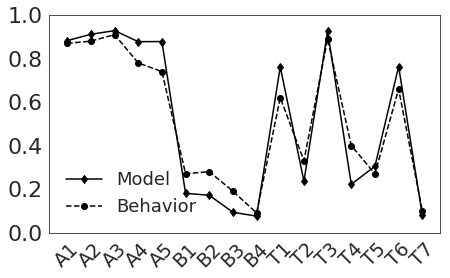

In [5]:
# %% Plotting

rehder_choice_data = np.array([
    [0.83, 0.87, 0.77],
    [0.82, 0.88, 0.79],
    [0.89, 0.91, 0.84],
    [0.79, 0.78, 0.71],
    [0.74, 0.74, 0.69],
    [0.3, 0.27, 0.34],
    [0.28, 0.28, 0.34],
    [0.15, 0.19, 0.27],
    [0.11, 0.09, 0.18],
    [0.62, 0.62, 0.59],
    [0.4, 0.33, 0.37],
    [0.88, 0.89, 0.78],
    [0.34, 0.4, 0.41],
    [0.4, 0.27, 0.33],
    [0.55, 0.66, 0.63],
    [0.17, 0.1, 0.23]])


plt.close('all')
sns.set_style('white')


def plot54(y, label=''):
    xtickSize   = 19
    ytickSize   = 22
    linestyles  = ['-', '--']
    markers     = ['d', 'o']
    plt.plot(range(1, 17), y, label=label, color='k',
             linestyle=linestyles['eh' in label],
             marker=markers['eh' in label])
    plt.xticks(range(1, 17),
               ['A1', 'A2', 'A3', 'A4', 'A5',
                'B1', 'B2', 'B3', 'B4',
                'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'],
               fontsize=xtickSize,
               rotation=45)
    plt.yticks(np.arange(
                0, 1.1, .2), np.arange(
                0, 1.01, .2).round(2), fontsize=ytickSize)


print("\ndims sampled at transfer by item: ")
transItemSamplesNormed = transItemSamples / (1.0 * param['NUM_TIMES'])
print(transItemSamplesNormed)

print("\nmean accuracy during training: %.3f"%(np.average(
    overall_correct) / (9. * param['NUM_TIMES'])))
print("mean fixations during training: %.3f"%(np.average(numberDimSampled) / (9.)))


print("mean number of samples per dimension during transfer: ",
      transSamplesAll / (16. * param['NUM_TIMES']))

plt.figure(figsize=(7, 4))
plot54(transferProbA / param['NUM_TIMES'], label='Model')
plot54(rehder_choice_data[:, 1], label='Behavior')
legend = plt.legend(frameon=0, fontsize=18, loc=3)


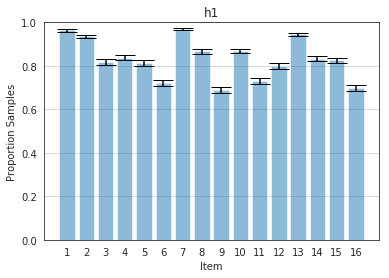

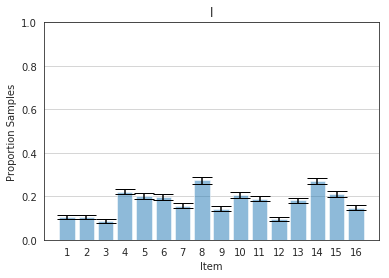

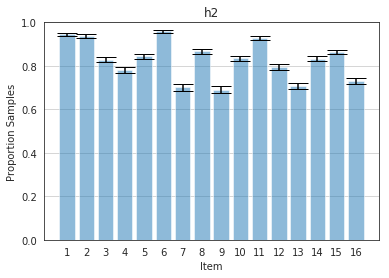

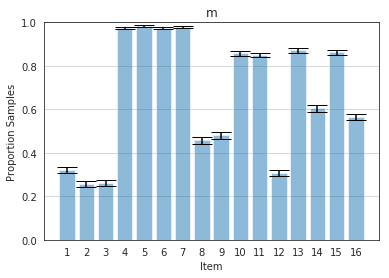

In [189]:
dfTransItems = pd.DataFrame(transItemSamples / (1.0 * param['NUM_TIMES']),columns=['h1','l','h2','m'])


cs = ['D%d'%d for d in range(1,5)]
dfTransItemSem = pd.DataFrame(np.zeros((16,4)),columns=dfTransItems.columns)
dfTransItemSD = pd.DataFrame(np.zeros((16,4)),columns=dfTransItems.columns)

for item in range(16):
    idxitem = dfTransDimSampled['item']==item
    dfTransDimSampled.loc[idxitem,:].shape
    dfTransItemSem.loc[item,dfTransItems.columns] = dfTransDimSampled.loc[idxitem,cs].sem().values
    dfTransItemSD.loc[item,dfTransItems.columns] = dfTransDimSampled.loc[idxitem,cs].std().values


for c in dfTransItems.columns:
    fig, ax = plt.subplots()
    ax.bar(range(1,17),dfTransItems[c], yerr=dfTransItemSem[c], 
           align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Proportion Samples')
    ax.set_xlabel('Item')
    ax.set_xticks(range(1,17))
    ax.set_ylim(0,1)
    ax.set_title(c)
    ax.yaxis.grid(True)
    plt.show()
    plt.pause(.01)

dfTransDimSampled.to_csv('results/54_dfTransDimSampled_%druns.csv'%param['NUM_TIMES'])

In [164]:
# bootstrap for confidence intervals
from tqdm import tqdm
cs=['D%d'%d for d in range(1,5)]
nboot = 100
nsamp=1000
idx = np.zeros(len(dfTransDimSampled))
dfBoot = pd.DataFrame(np.zeros((nboot,6)),columns=['iboot','item']+cs)
row=0
for iboot in (range(nboot)):
    runs = np.random.randint(0,nsamp, size=nsamp) # resample (same size with replacement)
    idxB = np.zeros(len(dfTransDimSampled))
    dftmp = pd.DataFrame(columns=['item']+cs)
    for irun,run in enumerate(runs):
        idx = dfTransDimSampled['run']==run
        dftmp = pd.concat([dftmp,dfTransDimSampled.loc[idx,['item']+cs]])

    for item in range(16):
        idxItem = dftmp['item']==item
        dfBoot.loc[row,'iboot'] = iboot
        dfBoot.loc[row,'item'] = item+1
        dfBoot.loc[row,cs] = dftmp.loc[idxItem,cs].mean().values
        row+=1
          

In [191]:
from scipy import stats
def mean_confidence_interval(data, confidence=0.95):
    '''returns, mn, mn-conf, mn+conf, conf'''
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h, h

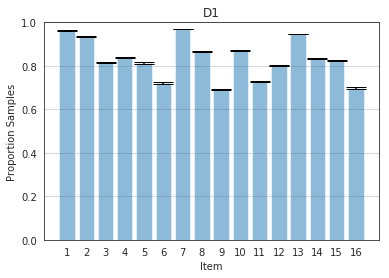

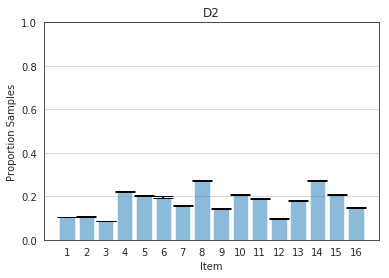

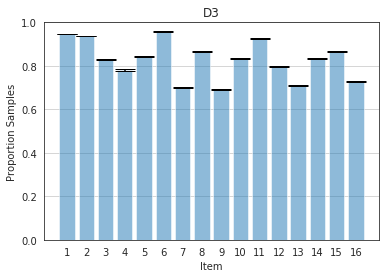

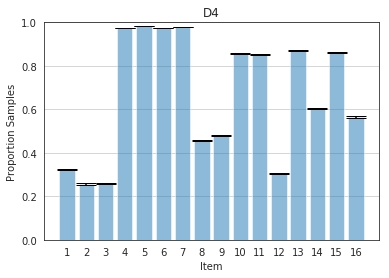

In [192]:
import seaborn as sns
# df=pd.DataFrame(np.zeros((16,4)),columns=cs)
dConf={c:[] for c in cs}
dMn = {c:[] for c in cs}
for item in range(16):
    idx = dfBoot['item']==item+1
    for c in cs:
        _,_,_,h = mean_confidence_interval(dfBoot.loc[idx,c])
        dConf[c].append(h)

dfTransItems.columns = ['D%d'%d for d in range(1,5)]
for c in dfTransItems.columns:
    fig, ax = plt.subplots()
    ax.bar(range(1,17),dfTransItems[c], yerr=dConf[c], 
           align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Proportion Samples')
    ax.set_xlabel('Item')
    ax.set_xticks(range(1,17))
    ax.set_ylim(0,1)
    ax.set_title(c)
    ax.yaxis.grid(True)
    plt.show()
    plt.pause(.01)